# 2.1 Kombiniertes Modell zur Ex Post Analyse

### Pakete einladen

In [ ]:
#%% Pakete laden
# interaktive Ploterstellung
#%matplotlib ipympl
import ipympl
# Grundpakete /Einspellungen
import os
import copy
import sys
from math import ceil
# Datenorganisation
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['axes.xmargin'] = 0
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option('display.precision',2)
np.set_printoptions(precision=3)

# statsmodells für Benchmark
from statsmodels import api as sm
import statsmodels.formula.api as smf

# Datenvorbereitung
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import cluster
import statsmodels.api as sm

# Keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
# Laden der Model-API
from keras.models import Model, Sequential
from keras.models import load_model
# Laden des Moduls Dense (zur Erstellung vollvermaschte Layer)
from keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, Conv1D,Conv2D,Concatenate,Flatten,MaxPooling1D,MaxPooling2D,GlobalMaxPooling1D, SeparableConv1D,TimeDistributed
from keras import layers,optimizers
# Callbacks zum Aufrufen während des Trainings
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Ausgabe der Modelarchitektur
from keras.utils import plot_model
import keras_tuner as kt

# Tensorflow
import tensorflow as tf
import tensorboard
from tensorboard.plugins.hparams import api as hp
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Löschen alter Metadaten und damit Freigabe bislang belegter ports 
from tensorboard import manager
tensorboard_dir = manager._get_info_dir()
for instance in os.listdir(tensorboard_dir):
    os.remove(os.path.join(tensorboard_dir,instance))

import sys
sys.path.append(r'../src')
import Datenvorbereitung as dv
from Datenvorbereitung import Sample_Split_Scaler, sample_generator_lags

#Feiertage
import holidays

ImportError: To use Keras, you need to have `optree` installed. Install it via `pip install optree`

### Vorbereitung der Daten

In [ ]:
#Daten einladen

data_Preise = pd.read_excel(r"../data/Daten_Preise.xlsx", sheet_name='Tabelle1', skiprows=1, index_col=0)
data_Preise = data_Preise.resample('h').ffill()
data_Preise.index = pd.to_datetime(data_Preise.index, format= "%Y-%m-%d %H:%M:%S")

ddata_Sonstige = pd.read_excel(r"../data/Daten_sonstige_h.xlsx", sheet_name='Tabelle1', skiprows=1, index_col=0)
data_Sonstige.index = pd.to_datetime(data_Sonstige.index, format= "%d.%m.%Y %H:%M")

# Index in ein einheitliches Format übertragne
data_Preise.index = data_Preise.index.strftime("%Y-%m-%d %H:%M:%S")
index1 = data_Preise.index
data_Sonstige.index = data_Sonstige.index.strftime("%Y-%m-%d %H:%M:%S")
index2 = data_Sonstige.index

#Daten in einem DataFrame zusammenfügen
data_roh = pd.merge(data_Sonstige, data_Preise, left_index=True, right_index=True, how='inner')
data_roh.index = pd.to_datetime(data_roh.index)

data_roh

,Wochentag,Prognose Wind Offshore [MWh],Prognose Wind Onshore [MWh],Prognose Photovoltaik [MWh],Prognose Sonstige [MWh],Prognose Gesamt (Netzlast) [MWh],Prognose Residuallast [MWh],Biomasse [MWh],Wasserkraft [MWh],Wind Offshore [MWh],Wind Onshore [MWh],Photovoltaik [MWh],Sonstige Erneuerbare [MWh],Kernenergie [MWh],Braunkohle [MWh],Steinkohle [MWh],Erdgas [MWh],Erzeugung Pumpspeicher [MWh],Sonstige Konventionelle [MWh],Gesamt (Netzlast) [MWh],Residuallast [MWh],Pumpspeicher [MWh],Nettoexport [MWh],Day-ahead Auktion (volumengewichtet) [€/MWh],Volumen (+) [MWh],Volumen (-) [MWh],Preis [€/MWh],Temperatur,Kohle [€/t],Gas [€/MWh],CO2 [€/t],BIP,Verbraucherpreisindex
ContractBegin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-05 00:00:00,2,551.75,10009.75,0.0,47097.50,43176.00,32614.50,4064.00,1680.25,473.75,11847.25,0.00,132.25,10934.50,16041.75,2201.50,987.00,1334.25,5207.00,46668.00,34347.00,2429.25,9906.00,17.93,0,-844,-37.56,3.40,64.7,7.24,20.35,100.0,100.0
2015-01-05 01:00:00,2,547.75,10287.75,0.0,44789.50,41597.75,30762.25,4069.25,1676.50,464.75,11814.75,0.00,131.00,11055.00,15390.50,2163.25,961.25,1038.25,4743.25,44627.00,32347.50,2823.00,10138.00,15.17,0,-589,-15.97,3.15,64.7,7.24,20.35,100.0,100.0
2015-01-05 02:00:00,2,542.50,10418.50,0.0,43457.00,40421.75,29460.75,4068.50,1661.50,461.50,12198.75,0.00,131.00,10861.00,15407.75,2012.00,983.00,265.50,5266.50,43635.50,30975.25,3629.75,10350.00,16.38,0,-625,-15.35,2.83,64.7,7.24,20.35,100.0,100.0
2015-01-05 03:00:00,2,533.75,10601.75,0.0,43335.50,40404.25,29268.75,4067.00,1644.00,450.25,12312.75,0.00,131.00,10760.00,15528.75,2049.25,996.75,274.00,5612.25,43683.25,30920.25,3438.00,10439.00,17.38,0,-494,-14.54,2.58,64.7,7.24,20.35,100.0,100.0
2015-01-05 04:00:00,2,521.75,10809.75,0.0,44479.50,41348.25,30016.75,4052.00,1632.00,453.50,13093.50,0.00,131.00,10632.75,15449.25,2783.50,1044.75,5.25,6223.75,44969.25,31422.25,3785.00,10705.00,16.38,0,-1294,-61.14,2.38,64.7,7.24,20.35,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 20:00:00,5,1230.00,5514.75,252.0,45566.25,58524.25,51527.50,4814.00,1441.25,1352.00,4361.75,188.75,129.25,3958.75,13538.25,8488.50,7066.25,3515.25,1286.75,59913.50,54011.00,1.00,3470.25,268.91,414,0,412.93,11.32,286.5,85.04,85.04,108.2,116.6
2022-04-28 21:00:00,5,1133.75,6178.00,0.0,43957.25,56366.25,49054.50,4778.75,1412.75,1362.50,5639.50,6.25,131.00,3962.00,13543.75,8457.25,6868.00,1715.00,1277.00,58205.25,51197.00,8.25,2767.00,253.56,136,-19,314.46,9.72,286.5,85.04,85.04,108.2,116.6
2022-04-28 22:00:00,5,1017.25,6537.00,0.0,42921.75,53424.75,45870.50,4665.75,1409.00,1200.00,5966.00,5.00,132.25,3971.50,13571.75,8382.75,6700.75,548.50,1278.25,54820.75,47649.75,84.00,3110.50,222.78,555,0,304.52,8.68,286.5,85.04,85.04,108.2,116.6


In [4]:
#Übertragen der Daten in einen anderen Dataframe als Backup
data_roh
df_cleaned = data_roh

## Feature Engineering

In [4]:
#Ideen für Feature Engineering

#Zeitliche Einflüsse
#Tag des Jahres
df_cleaned["Day-of-year"] = df_cleaned.index.dayofyear
#Monat
df_cleaned["Monat"] = df_cleaned.index.month
# Stunde des Tages
df_cleaned["Stunde"] = df_cleaned.index.hour
#Feiertage
de_holidays = holidays.Germany(years=range(2015, 2022))
df_cleaned['Feiertag'] = df_cleaned.index.isin(de_holidays).astype(int)


#Berücksichtigung Ausgleichsenergie spez. Kosten 
df_cleaned["Ausgleichsenergie [€]"] = (df_cleaned["Volumen (+) [MWh]"]+df_cleaned["Volumen (-) [MWh]"])*df_cleaned["Preis [€/MWh]"] #Überprüft nicht geeignet. Kein Zusammenhang mit großer Auswirkung erkennbar


#Kraftwerke mit Preisen
df_cleaned['Summe_CO2'] = df_cleaned['Braunkohle [MWh]']* 1.188 +df_cleaned['Steinkohle [MWh]']* 0.95 +df_cleaned['Erdgas [MWh]']*0.4
df_cleaned['Summe_Kohle'] = df_cleaned['Braunkohle [MWh]']*0.2398 +df_cleaned['Steinkohle [MWh]']*0.1228
df_cleaned['Kraftwerke_CO2'] = (df_cleaned['Braunkohle [MWh]']* 1.188 +df_cleaned['Steinkohle [MWh]']* 0.95 +df_cleaned['Erdgas [MWh]']*0.4)*df_cleaned['CO2 [€/t]']
df_cleaned['Kraftwerke_Kohle'] = (df_cleaned['Braunkohle [MWh]']*0.2398 +df_cleaned['Steinkohle [MWh]']*0.1228 )*df_cleaned['Kohle [€/t]']
df_cleaned['Kraftwerke_Gas'] = df_cleaned['Erdgas [MWh]']*df_cleaned['Gas [€/MWh]']
df_cleaned['Kosten_Erdgas'] = (df_cleaned['Erdgas [MWh]']* df_cleaned['Gas [€/MWh]'])+ (df_cleaned['Erdgas [MWh]']*0.4*df_cleaned['CO2 [€/t]'])
df_cleaned['Kosten_Braunkohle'] = (df_cleaned['Braunkohle [MWh]']*0.2398*df_cleaned['Kohle [€/t]'])+ (df_cleaned['Braunkohle [MWh]']*1.188*df_cleaned['CO2 [€/t]'])
df_cleaned['Kosten_Steinkohle'] = (df_cleaned['Steinkohle [MWh]']*0.1228*df_cleaned['Kohle [€/t]'])+ (df_cleaned['Steinkohle [MWh]']*0.95*df_cleaned['CO2 [€/t]'])
df_cleaned['Kraftwerke_Fossil'] = df_cleaned['Kraftwerke_Gas']*df_cleaned['Kraftwerke_Kohle']*df_cleaned['Kraftwerke_CO2']

#Quellen-CO2: 
#Braunkohle: hhttps://www.bund-nrw.de/braunkohle/hintergruende-und-publikationen/braunkohlenkraftwerke-contra-klimaschutz/
#Steinkohle: https://www.brisant.de/braunkohle-umwelt-100.html
#Erdgas: https://www.ise.fraunhofer.de/de/presse-und-medien/news/2019/33-prozent-weniger-co2-emissionen-durch-brennstoffwechsel-von-kohle-auf-gas.html

#Quellen-Kohle:
#Braunkohle: https://agrarplus.at/heizwerte-aequivalente.html
#Steinkohle: https://www.unitjuggler.com/energy-umwandeln-von-MWh-nach-tSKE.html


# Anteil Erneuerbarer
df_cleaned['Summe_Ern']= df_cleaned[['Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]','Biomasse [MWh]', 'Sonstige Erneuerbare [MWh]','Wasserkraft [MWh]',]].sum(axis=1)
df_cleaned['Anteil Erneuerbarer'] = df_cleaned['Summe_Ern'] / (df_cleaned['Gesamt (Netzlast) [MWh]']) * 100
df_cleaned['Anteil_PV'] = df_cleaned['Photovoltaik [MWh]']/df_cleaned['Summe_Ern']
df_cleaned['Anteil_Offshore'] = df_cleaned['Wind Offshore [MWh]']/df_cleaned['Summe_Ern']

df_cleaned['Prognose_Summe_Ern']= df_cleaned[['Prognose Wind Offshore [MWh] ', 'Prognose Wind Onshore [MWh]', 'Prognose Photovoltaik [MWh]']].sum(axis=1)
prog_proz_ern = df_cleaned['Prognose_Summe_Ern'] / (df_cleaned[' Prognose Gesamt (Netzlast) [MWh]']) * 100
df_cleaned['Prognose Anteil Erneuerbarer'] = prog_proz_ern

# Überschuss Erzeugung
summe_erzeugung = df_cleaned[['Biomasse [MWh]', 'Wasserkraft [MWh]',
       'Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]',
       'Sonstige Erneuerbare [MWh]', 'Kernenergie [MWh]', 'Braunkohle [MWh]',
       'Steinkohle [MWh]', 'Erdgas [MWh]', 'Erzeugung Pumpspeicher [MWh]',
       'Sonstige Konventionelle [MWh]']].sum(axis=1)
df_cleaned['Überschuss'] = summe_erzeugung - df_cleaned['Gesamt (Netzlast) [MWh]']


# Abweichung Prognose Residuallast
df_cleaned['Abweichung_Prognose_Residuallast'] = (df_cleaned['Residuallast [MWh]'] - df_cleaned['Prognose Residuallast [MWh]'])


#mögliche Interaktionen zwischen Features
df_cleaned['Int_Gas'] = df_cleaned['Gas [€/MWh]']*df_cleaned['Gesamt (Netzlast) [MWh]']
df_cleaned['Int_Gas_Resi'] = df_cleaned['Gas [€/MWh]']*df_cleaned['Residuallast [MWh]']
df_cleaned['Int_CO2_Erz'] = summe_erzeugung*df_cleaned['CO2 [€/t]']
df_cleaned['Int_CO2_Kohle'] = df_cleaned['Braunkohle [MWh]']* 1.188 +df_cleaned['Steinkohle [MWh]']* 0.95*df_cleaned['CO2 [€/t]']
df_cleaned['Int_Ern_Foss'] = df_cleaned['Anteil Erneuerbarer'] * df_cleaned['Erdgas [MWh]']*df_cleaned['Steinkohle [MWh]']*df_cleaned['Braunkohle [MWh]']
df_cleaned['Int_Preise'] = df_cleaned['Kraftwerke_CO2']*df_cleaned['Kraftwerke_Kohle']*df_cleaned['Kraftwerke_Gas']
df_cleaned['Int_Pumpspeicher'] = df_cleaned['Pumpspeicher [MWh]']/df_cleaned['Kraftwerke_Fossil']

# Versuch Einbau der Merit-Order als Feature
merit_order = ['Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]', 'Wasserkraft [MWh]','Biomasse [MWh]',
               'Sonstige Erneuerbare [MWh]', 'Kernenergie [MWh]', 'Braunkohle [MWh]', 'Steinkohle [MWh]', 'Erdgas [MWh]',
               'Erzeugung Pumpspeicher [MWh]', 'Sonstige Konventionelle [MWh]']

df_order = df_cleaned[merit_order]
df_cumsum = df_order.cumsum(axis=1)

gesamtlast_serie = df_cleaned['Gesamt (Netzlast) [MWh]']

def finde_lastdeckung(row, gesamtlast):
    for kraftwerk, kum_erz in row.items():
        if kum_erz >= gesamtlast:
            return kraftwerk, kum_erz
        return None, None

#df_cleaned['Deckendes Kraftwerk'], df_cleaned['Erzeugung bei Deckung'] = zip(*df_cumsum.apply(lambda row: finde_lastdeckung(row, gesamtlast_serie[row.name]), axis = 1))
#print(df_cleaned[['Deckendes Kraftwerk', 'Erzeugung bei Deckung']])

#Standardabweichung
#df_cleaned['Std_Gas'] = df_cleaned['Gas [€/MWh]'].rolling(window=24).std()
#df_cleaned['Std_Kohle'] = df_cleaned['Kohle [€/t]'].rolling(window=24).std()
#df_cleaned['Std_CO2'] = df_cleaned['CO2 [€/t]'].rolling(window=24).std()
#df_cleaned['Std_Erneuerbare_Tag'] = df_cleaned['Summe_Ern'].rolling(window=24).std()
#df_cleaned['Std_Prognose'] = df_cleaned['Abweichung_Prognose_Residuallast'].rolling(window=24).std()



#Gleitender Durchschnitt Preise
#df_cleaned['Moving_Average_Gas'] = df_cleaned['Gas [€/MWh]'].rolling(window=2500).mean()
#df_cleaned['Moving_Average_Kohle'] = df_cleaned['Kohle [€/t]'].rolling(window=2500).mean()
#df_cleaned['Moving_Average_CO2'] = df_cleaned['CO2 [€/t]'].rolling(window=2500).mean()

df_cleaned = df_cleaned.dropna()
df_cleaned = df_cleaned.loc[:'2021-05-01']

#Spalten löschen
df_cleaned = df_cleaned.drop(['Volumen (+) [MWh]', 'Volumen (-) [MWh]', 'Preis [€/MWh]'], axis=1)


C:\Users\Dominik\AppData\Local\Temp\ipykernel_3564\1213051947.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_cleaned['Feiertag'] = df_cleaned.index.isin(de_holidays).astype(int)


In [17]:
# Vorgaben zur Datentrennung
sections=(.6,.2,.2)
shuffle=False

#Ausgewählte Features
features = df_cleaned[['Stunde', 'Wochentag', 'Day-of-year', 'Monat', 'Kraftwerke_Kohle', 'Kraftwerke_Gas', 'Kraftwerke_CO2',
                       'Ausgleichsenergie [€]', 'Anteil Erneuerbarer', 'Überschuss','Int_Pumpspeicher', 'Nettoexport [MWh]',
                       'Residuallast [MWh]', 'Abweichung_Prognose_Residuallast', 'Int_Gas_Resi', 'Temperatur',
                       'Kernenergie [MWh]','Erdgas [MWh]', 'Braunkohle [MWh]', 'Steinkohle [MWh]','Prognose Wind Offshore [MWh] ',
                       'Prognose Wind Onshore [MWh]', 'Prognose Photovoltaik [MWh]',' Prognose Gesamt (Netzlast) [MWh]','Biomasse [MWh]', 
                       'Wasserkraft [MWh]','Sonstige Erneuerbare [MWh]', 'Erzeugung Pumpspeicher [MWh]', 'Feiertag']]

# Vorbereitete Klasse
KNN = Sample_Split_Scaler()

# Unterteilung der Samples
KNN.split_sample(features,df_cleaned['Day-ahead Auktion (volumengewichtet) [€/MWh]'].values.reshape(-1,1),shuffle=False,sections =sections)

#Auswahl der Skalierungsmethode "MinMax" vs. "standard"
KNN.scaler("MinMax")

In [18]:
# vier Inputs
def sample_generator(x,y,KNN,epochs,satz,zs_length):
    while True:
        # Generator erstellen 
        # schleife über Epochen
        for epo in range(epochs):
            # Erstellung der Batches (Satz = Training, Val oder Test {1,2,3})
            for i in range(0,KNN.steps[satz]-1):
                x_,y_=[],[]
                # Bereich
                idx_range = range(KNN.shunks[satz][i],KNN.shunks[satz][i+1])
                for idx in idx_range:
                    x_.append(x[idx:idx+zs_length])
                    y_.append(np.squeeze(y[idx+np.int32(zs_length/2)]))
                x_=np.array(x_,dtype='float64')
                xshape=x_.shape
                y_=np.array(y_,dtype='float64')
                yshape=y_.shape
                yield (x_[:, :, [0,1,2,3,4,5,6]],x_[:, :, [0,1,2,3,4,7,8,9,10,11,12,13,14,15]], x_[:, :, [16,17,18,19,20,21,22,23,24,25,26,27]], x_[:,:, [28]]), y_

### Modellstruktur

In [ ]:
# Modell; vier Inputs
data_length = 168

#Input 1                                                                                          
input1 = keras.Input(shape=(data_length, 7))                                        
x1 = keras.layers.Conv1D(filters=512, kernel_size=24, activation="relu")(input1)                  
x1 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu")(x1)                       
x1 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu")(x1)                                                                
x1 = keras.layers.MaxPooling1D(pool_size=2)(x1) 
x1 = keras.layers.Dropout(0.3)(x1) 
x1 = keras.layers.LSTM(units=128, return_sequences=True)(x1)  
x1 = keras.layers.LSTM(units=128, return_sequences=False)(x1)  

#Input 2 
input2 = keras.Input(shape=(data_length,14))
x2 = keras.layers.Conv1D(filters=512, kernel_size=24, activation="relu",padding='same')(input2)   
x2 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu",padding='same')(x2)        
x2 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu",padding='same')(x2)         
x2 = keras.layers.MaxPooling1D(pool_size=2)(x2) 
x2 = keras.layers.LSTM(units=128, return_sequences=True)(x2)            
x2 = keras.layers.LSTM(units=128, return_sequences=False)(x2)              

#Input 3 
input3 = keras.Input(shape=(data_length,11))
x3 = keras.layers.Conv1D(filters=512, kernel_size=24, activation="relu",padding='same')(input3)   
x3 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu",padding='same')(x3)        
x3 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu",padding='same')(x3)         
x3 = keras.layers.MaxPooling1D(pool_size=2)(x3) 
x3 = keras.layers.Dense(512, activation="relu")(x3)
x3 = keras.layers.Dense(256, activation="relu")(x3)
x3 = keras.layers.Dense(128, activation="relu")(x3)
x3 = keras.layers.Dense(64, activation="relu")(x3)
x3 = keras.layers.Dense(32, activation="relu")(x3)
x3 = keras.layers.Flatten()(x3)

#Input 4 
input4 = keras.Input(shape=(data_length,1))
x4 = keras.layers.Flatten()(input4)

# Zusammenfügen
merged = keras.layers.concatenate([x1, x2, x3, x4])                 
dense = keras.layers.Dense(64, activation="relu")(merged)                                     
outputs = keras.layers.Dense(1, activation="linear")(dense)

# Modell kompilieren
KNN.model = Model(inputs=[input1,input2,input3,input4], outputs=outputs)
KNN.lr = 0.00001 
KNN.optimizer = optimizers.Adam(KNN.lr)
KNN.model.compile(loss='mse', optimizer=KNN.optimizer, metrics=['mae'])
KNN.model.summary()

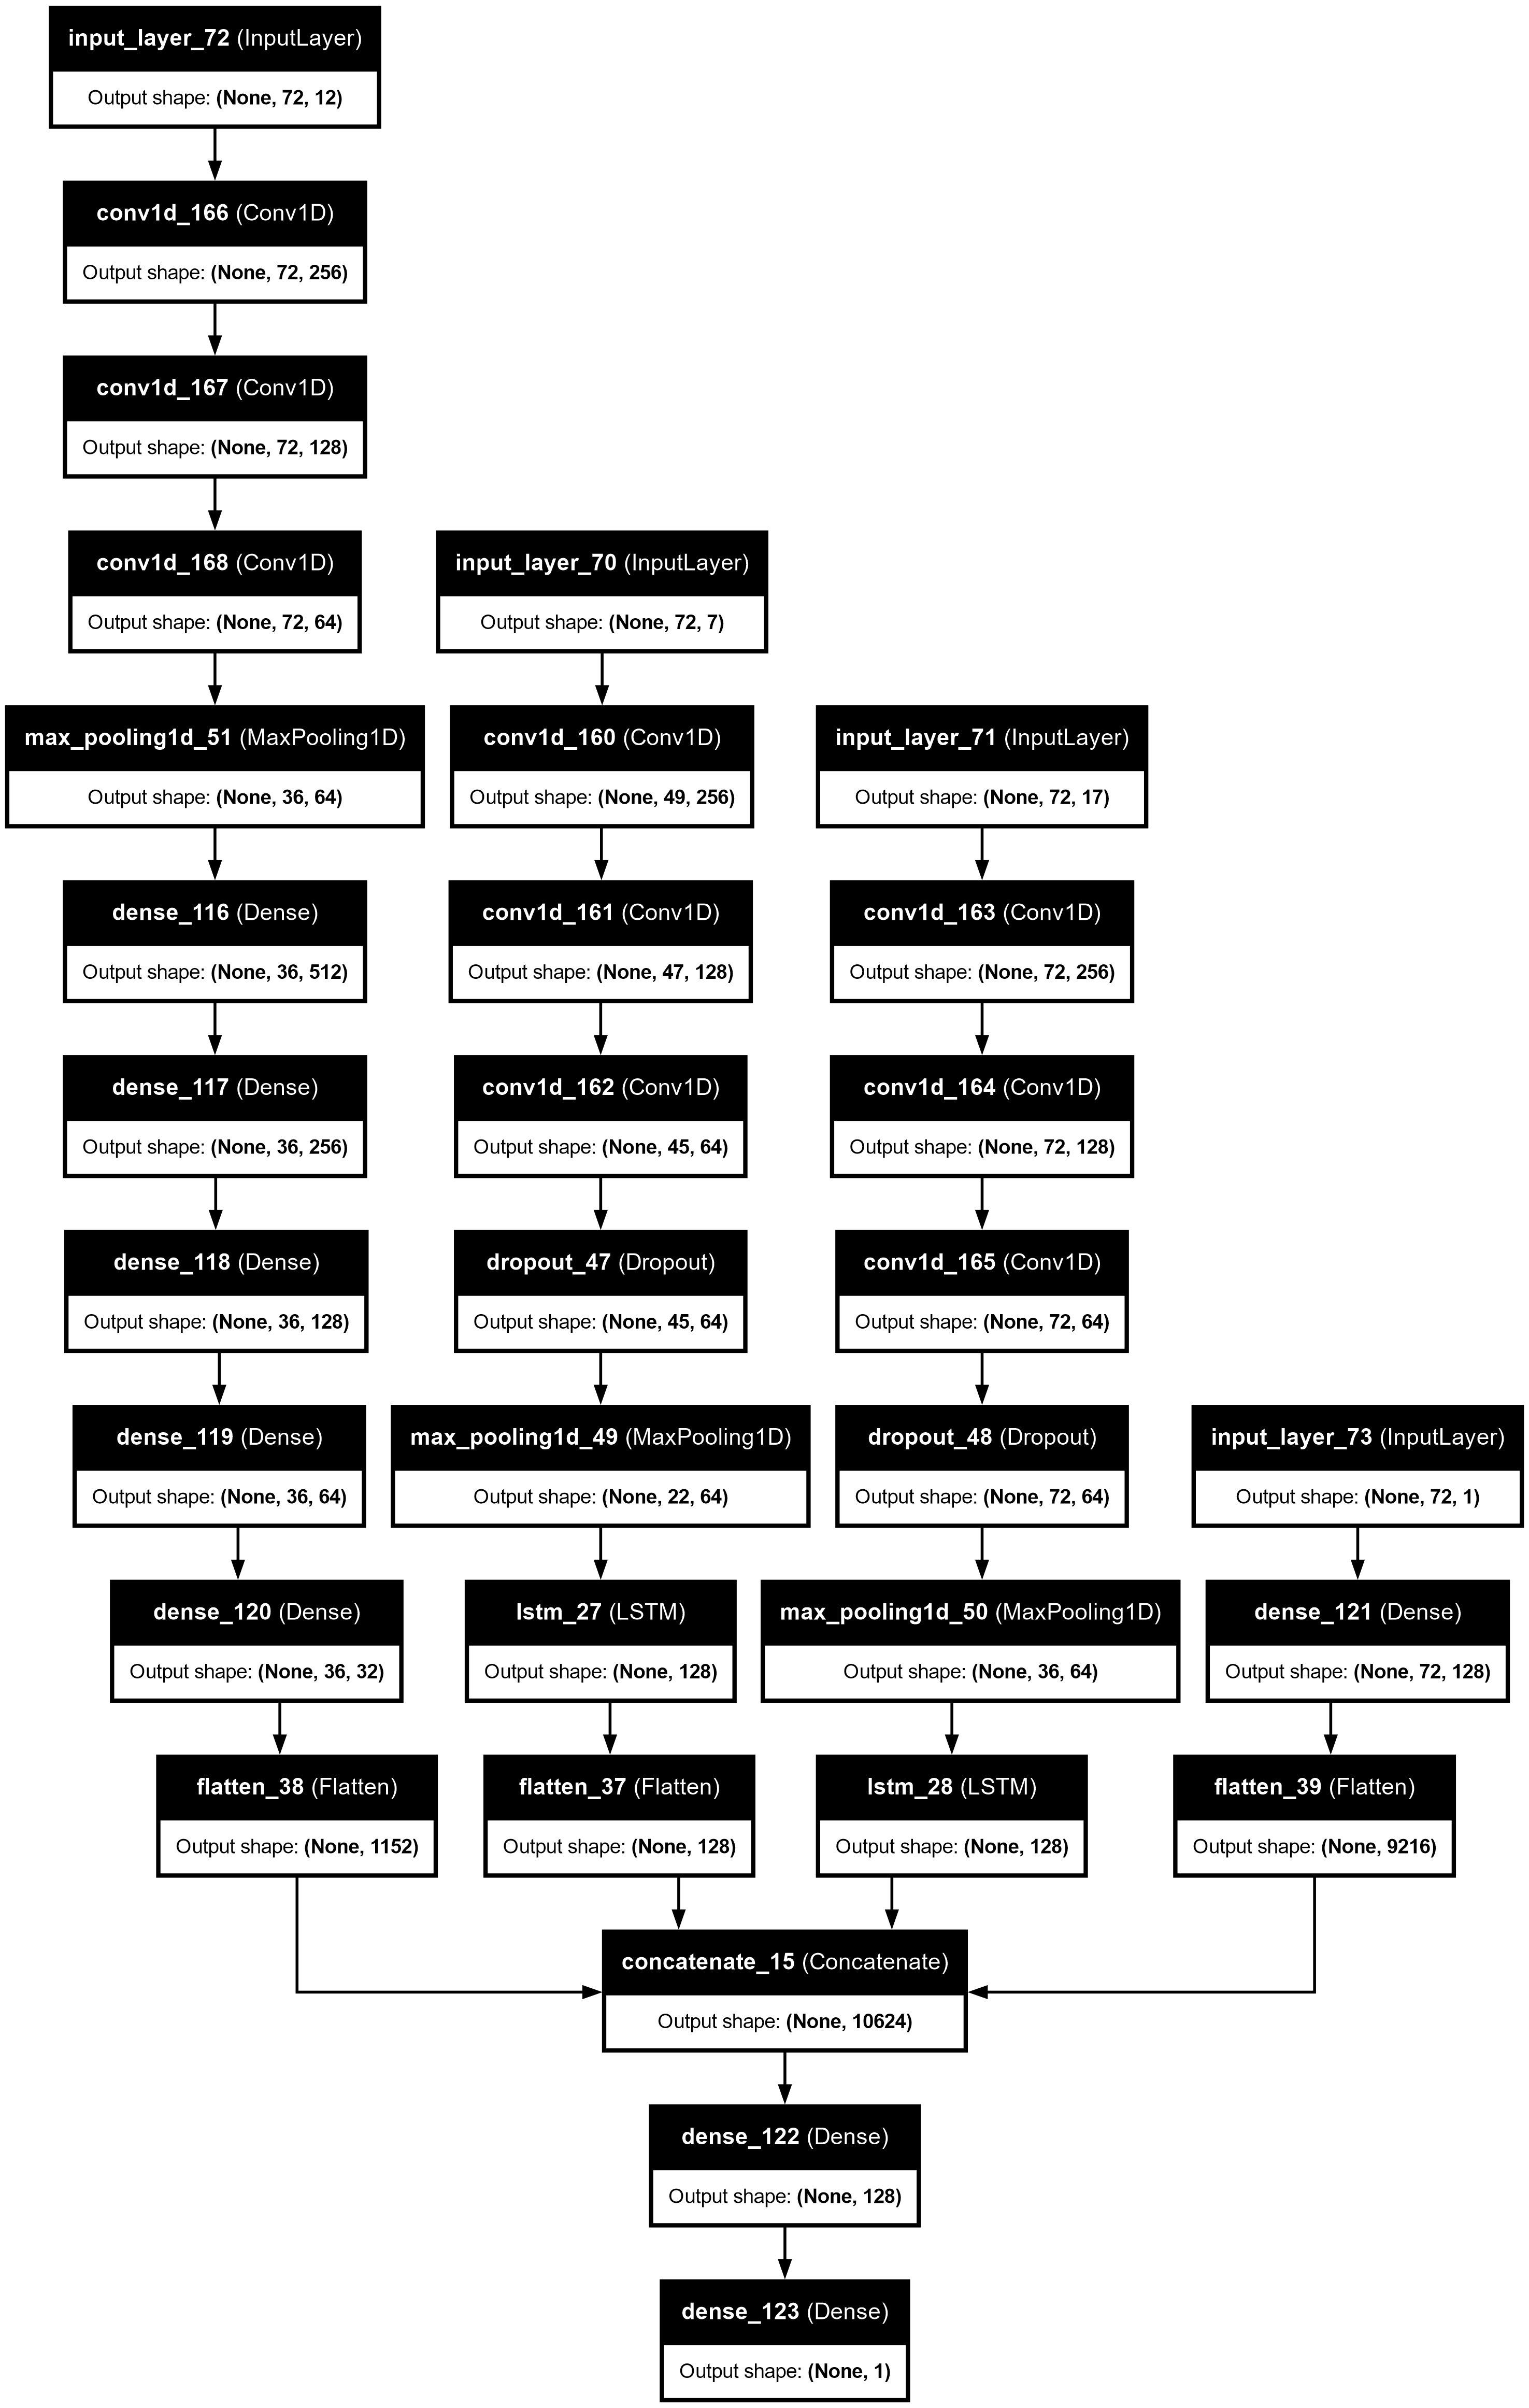

In [ ]:
plot_model(KNN.model, to_file='model1_architektur.png', show_shapes=True, show_layer_names=True)

### Modell trainieren

In [131]:
# Anzahl Samples  # 0 = train, 1= val, 2= test
batch_size = 1680 #händisch überprüft
KNN.sample_laenge = [len(KNN.x_norm[i]) - data_length for i in range(3)]
KNN.batch_size = [min(KNN.sample_laenge[i], batch_size) for i in range(3)]
KNN.steps = [int(np.floor(KNN.sample_laenge[i] / KNN.batch_size[i])) for i in range(3)]
KNN.shunks = [list(range(0, KNN.sample_laenge[i], KNN.batch_size[i])) for i in range(3)]
for i in range(3):
    KNN.shunks[i][-1] = KNN.sample_laenge[i]
KNN.epochs = 500

In [132]:
KNN.early = EarlyStopping(monitor='val_loss', patience=40)
KNN.check = ModelCheckpoint(filepath='KNN.keras', monitor='val_loss', save_best_only=True)
gen = [sample_generator(KNN.x_norm[i], KNN.y_norm[i], KNN, KNN.epochs, i, data_length) for i in range(3)]
with tf.device('/GPU:1'):
    KNN.history = KNN.model.fit(gen[0], epochs=KNN.epochs, steps_per_epoch=KNN.steps[0], \
                            validation_data=(gen[1]),validation_steps = KNN.steps[1], \
                              callbacks=[KNN.early, KNN.check])

Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 0.2786 - mae: 0.5256 - val_loss: 0.1076 - val_mae: 0.3231
Epoch 2/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 0.1469 - mae: 0.3736 - val_loss: 0.0039 - val_mae: 0.0461
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0115 - mae: 0.0881 - val_loss: 0.0183 - val_mae: 0.1217
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 0.0026 - mae: 0.0381 - val_loss: 0.0095 - val_mae: 0.0812
Epoch 5/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0027 - mae: 0.0378 - val_loss: 0.0122 - val_mae: 0.0969
Epoch 6/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0024 - mae: 0.0350 - val_loss: 0.0120 - val_mae: 0.0959
Epoch 7/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0024 - mae: 0.0347 - val_loss: 0.0111 - val_mae: 0.0928
Epoch 8/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0024 - mae: 0.0353 - val_loss: 0.0100 - val_mae: 0.0873
Epoch 9/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.002

## Ergebnisse

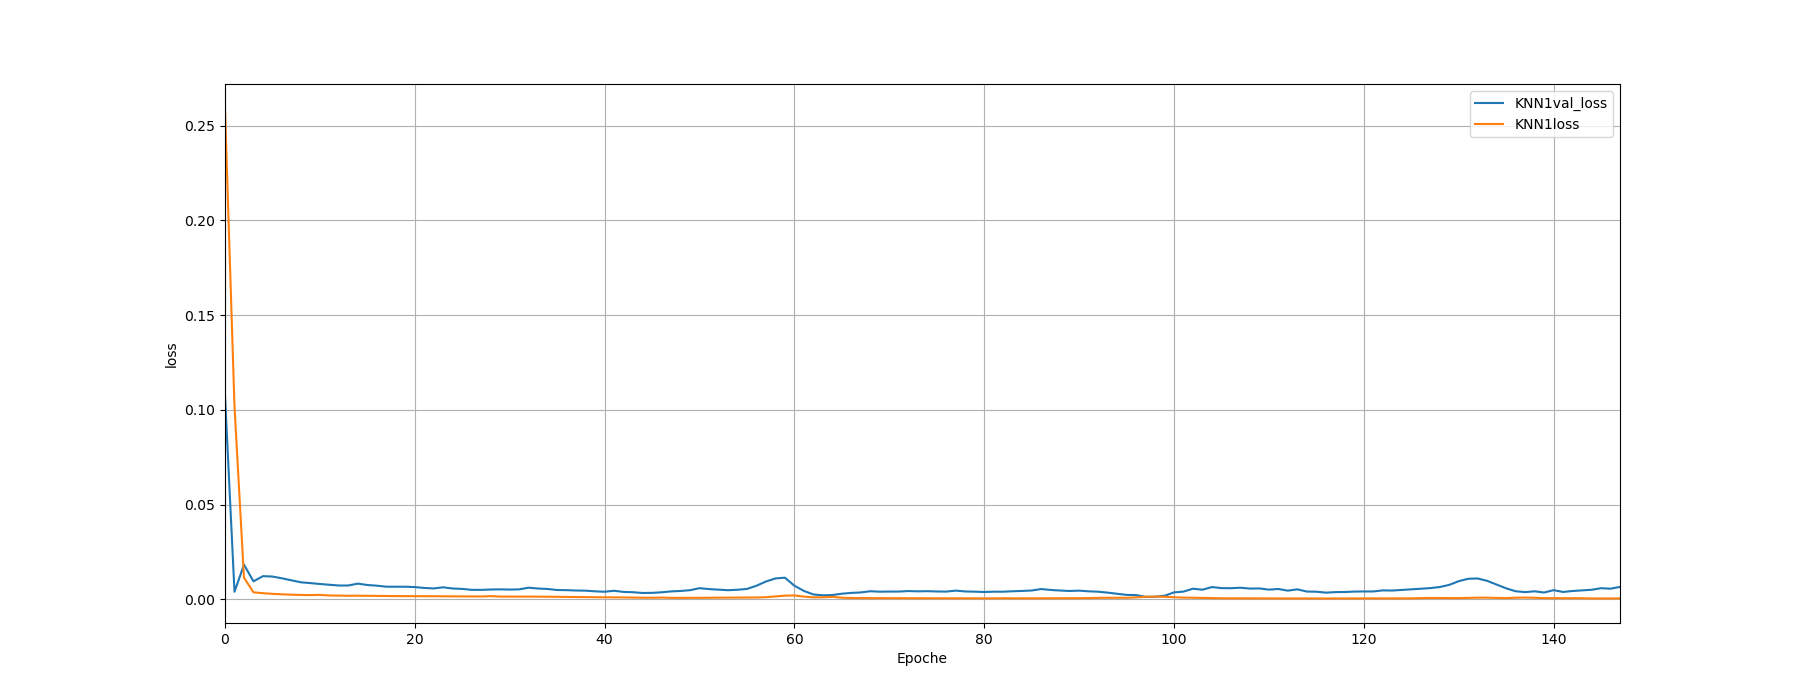

In [133]:
fig, ax =plt.subplots(nrows=1,ncols=1,**{'figsize': (18, 7)})
lin1 = ax.plot(KNN.history.history['val_loss'],label='KNN1val_loss')
lin2 = ax.plot(KNN.history.history['loss'],label='KNN1loss')
ax.set(xlabel='Epoche',ylabel='loss')
ax.legend();ax.grid(visible=True)

In [134]:
### Bestes Modell laden
model = keras.saving.load_model("KNN.keras",safe_mode=False)

#%% Anwendung auf die Testdaten: Berechnung Verlust (Loss and metric)
gen=[];KNN.x_in=[];KNN.y_in=[];KNN.loss=[];KNN.ypred_norm=[];KNN.ypred=[];ypred_vgl=[];

loss =pd.DataFrame(index =["Loss","MAE"])    
col_name=["Training","Validierung","Test"]

for i in range(3):  
    gen.append(sample_generator(KNN.x_norm[i],KNN.y_norm[i],KNN,1,i,data_length))        # Generator wird reinitialisiert 
    tmp=next(gen[i])                                                                     # Batch gezogen
    KNN.x_in.append(tmp[0]);                                                             # Regressoren
    KNN.y_in.append(tmp[1]);                                                             # Regressand

    # Berechnung Fehler                                                                                                        
    error=np.array(KNN.model.evaluate(KNN.x_in[i],KNN.y_in[i]))
    if KNN.scaler_method=='MinMax':
        value=np.round(KNN.scalerY.inverse_transform(error.reshape(-1, 1))-KNN.scalerY.min_,0)
    else:
        value =np.round(KNN.scalerY.inverse_transform(error.reshape(-1, 1))-KNN.scalerY.mean_,0)
    loss.insert(loc =i,value =error ,column=col_name[i])
    
    # Berechnung Prognose
    KNN.ypred_norm.append(KNN.model.predict(KNN.x_in[i])) 
    KNN.ypred.append(KNN.scalerY.inverse_transform(KNN.ypred_norm[i]))
    # Vergleichswert
    ypred_vgl.append(KNN.scalerY.inverse_transform(KNN.y_in[i].reshape(-1, 1)))
    
loss

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.8601e-04 - mae: 0.0190
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0085 - mae: 0.0885
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0052 - mae: 0.0622
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


,Training,Validierung,Test
Loss,5.69e-04,7.65e-03,5.12e-03
MAE,1.85e-02,8.31e-02,5.70e-02


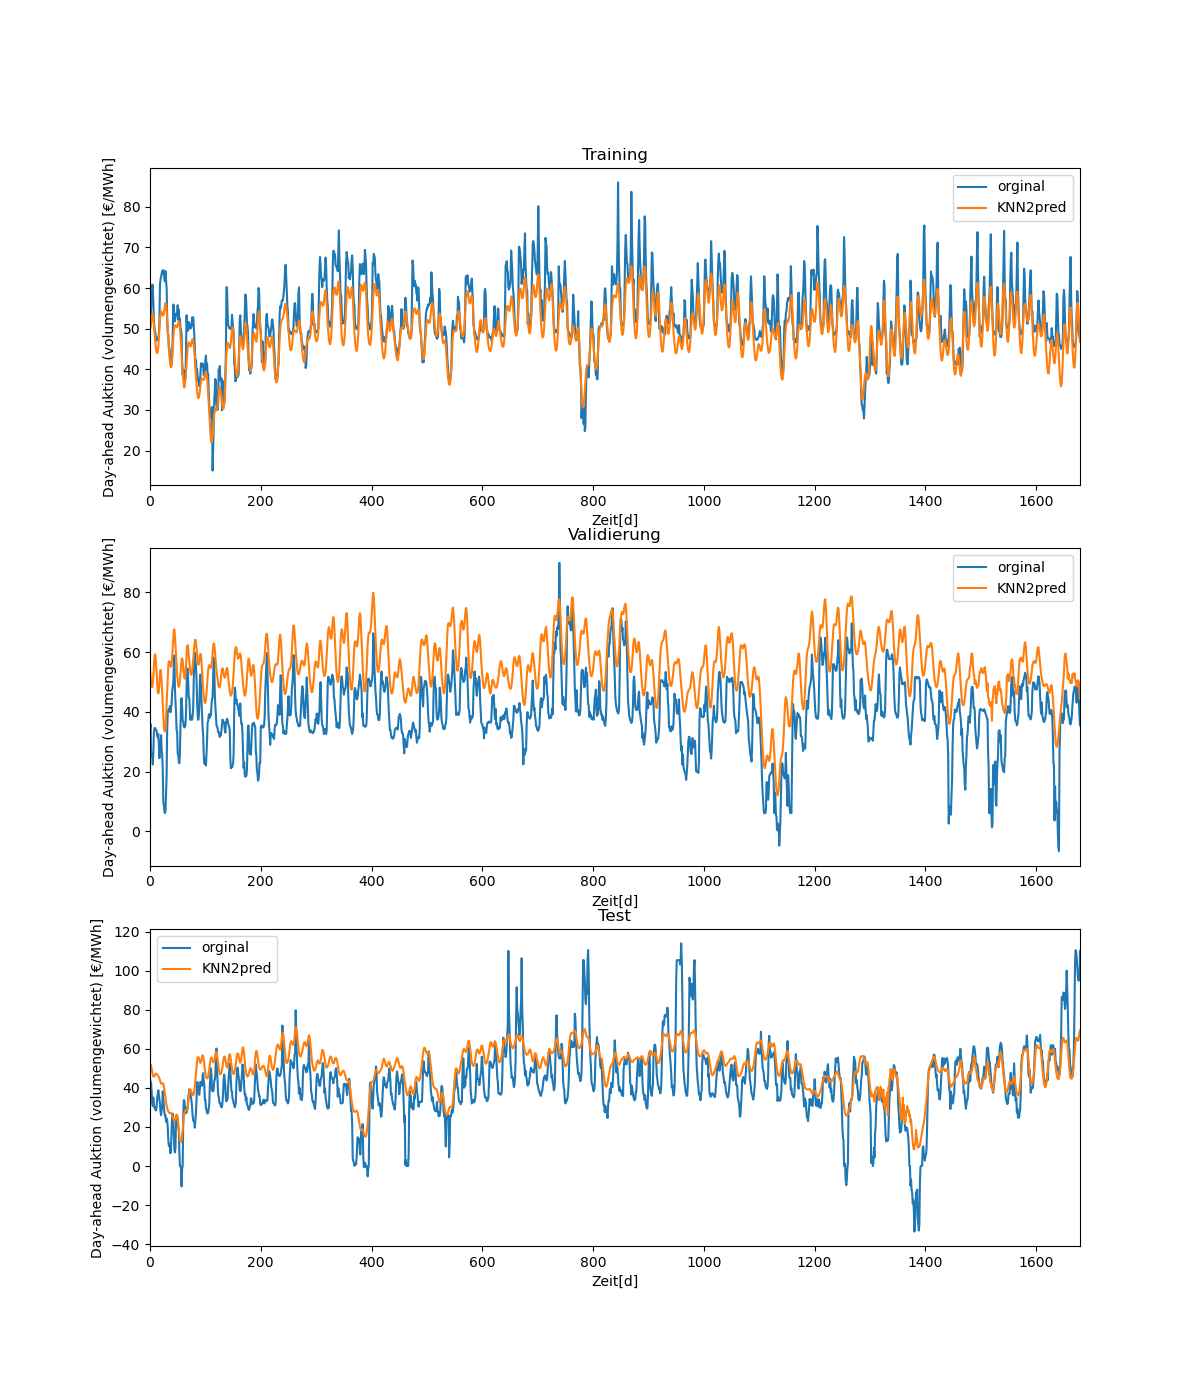

In [135]:
fig, ax =plt.subplots(nrows=3,ncols=1,**{'figsize': (12, 14)});lab=["Training","Validierung","Test"]
for i in range(3):
    lin1=ax[i].plot(KNN.scalerY.inverse_transform(KNN.y_in[i].reshape(-1, 1)),label='orginal',linestyle=None);
    #lin2=ax[i].plot(KNN.scalerX.inverse_transform(KNN.x_in[i][:,np.int32(zs_length/2),0].reshape(-1, 1)),label='WLG',linestyle=None);
    lin3=ax[i].plot(KNN.ypred[i],label='KNN2pred',linestyle=None);
    ax[i].set(ylabel="Day-ahead Auktion (volumengewichtet) [€/MWh]",xlabel="Zeit[d]",title=lab[i]);
    ax[i].legend()

### Hyperparameteroptimierung

In [35]:
# Festlegung der verschiedenen Hyperparameter
HP_units_dense = hp.HParam(name="units_dense",domain = hp.Discrete([64, 128]))     # Anzahl der Neuronen Dense-Layer
HP_units_LSTM = hp.HParam(name="units_LSTM",domain = hp.Discrete([64, 128]))     # Anzahl der Neuronen LSTM-Layer
HP_lr = hp.HParam(name = "lr", domain= hp.RealInterval(min_value=1.0, max_value=3.0))     # Lernrate
HP_data_length = hp.HParam(name='data_length', domain=hp.Discrete([72, 168]))
HP_pool_size = hp.HParam(name='pool_size', domain=hp.Discrete([2, 4]))

In [36]:
# Modellaufbau mit gewählter Hyperparameterausstattung

def single_run(hparams):

    # Modell; vier Inputs
    data_length = hparams[HP_data_length] # 72 oder 168

    #Input 1                                                                                          
    input1 = keras.Input(shape=(data_length, 7))                                        
    x1 = keras.layers.Conv1D(filters=512, kernel_size=24, activation="relu")(input1)                  
    x1 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu")(x1)                       
    x1 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu")(x1)                        
    x1 = keras.layers.Dropout(0.3)(x1)                                                                
    x1 = keras.layers.MaxPooling1D(pool_size=hparams[HP_pool_size])(x1)     # 2 oder 4                                              
    x1 = keras.layers.LSTM(units=hparams[HP_units_LSTM], return_sequences=True)(x1)  #128 oder 64
    x1 = keras.layers.LSTM(units=hparams[HP_units_LSTM], return_sequences=False)(x1)  #128 oder 64

    #Input 2 
    input2 = keras.Input(shape=(data_length,17))
    x2 = keras.layers.Conv1D(filters=512, kernel_size=24, activation="relu",padding='same')(input2)   
    x2 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu",padding='same')(x2)        
    x2 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu",padding='same')(x2)         
    x2 = keras.layers.MaxPooling1D(pool_size=hparams[HP_pool_size])(x2)              # 2 oder 4                                        
    x2 = keras.layers.LSTM(hparams[HP_units_LSTM], return_sequences=True)(x2)            #128 oder 64                         
    x2 = keras.layers.LSTM(hparams[HP_units_LSTM], return_sequences=False)(x2)              #128 oder 64                     

    #Input 3 
    input3 = keras.Input(shape=(data_length,12))
    x3 = keras.layers.Conv1D(filters=512, kernel_size=24, activation="relu",padding='same')(input3)   
    x3 = keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu",padding='same')(x3)        
    x3 = keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu",padding='same')(x3)         
    x3 = keras.layers.MaxPooling1D(pool_size=hparams[HP_pool_size])(x3)                   # 2 oder 4                              
    x3 = keras.layers.Dense(512, activation="relu")(x3)
    x3 = keras.layers.Dense(256, activation="relu")(x3)
    x3 = keras.layers.Dense(128, activation="relu")(x3)
    x3 = keras.layers.Dense(64, activation="relu")(x3)
    x3 = keras.layers.Dense(32, activation="relu")(x3)
    x3 = keras.layers.Flatten()(x3)

    #Input 4 
    input4 = keras.Input(shape=(data_length,1))
    x4 = keras.layers.Flatten()(input4)

    # Zusammenfügen
    merged = keras.layers.concatenate([x1, x2, x3, x4])
    dense = keras.layers.Dense(hparams[HP_units_dense], activation="relu")(merged)        #128 oder 64                                
    outputs = keras.layers.Dense(1, activation="linear")(dense)

    # Modell kompilieren
    KNN.model = Model(inputs=[input1,input2,input3,input4], outputs=outputs)
    KNN.lr = hparams[HP_lr] 
    KNN.optimizer = optimizers.Adam(KNN.lr)
    KNN.model.compile(loss='mse', optimizer=KNN.optimizer, metrics=['mae'])
    
    return KNN

In [39]:
def run(run_dir,hparams):
    KNN = single_run(hparams)

    batch_size = 1680
    KNN.sample_laenge = [len(KNN.x_norm[i]) - data_length for i in range(3)]
    KNN.batch_size = [min(KNN.sample_laenge[i], batch_size) for i in range(3)]
    KNN.steps = [int(np.floor(KNN.sample_laenge[i] / KNN.batch_size[i])) for i in range(3)]
    KNN.shunks = [list(range(0, KNN.sample_laenge[i], KNN.batch_size[i])) for i in range(3)]
    for i in range(3):
        KNN.shunks[i][-1] = KNN.sample_laenge[i]
    KNN.epochs = 20
    KNN.early = EarlyStopping(monitor='val_loss', patience=5)
    KNN.check = ModelCheckpoint(filepath='KNN.keras', monitor='val_loss', save_best_only=True)
    gen = [sample_generator(KNN.x_norm[i], KNN.y_norm[i], KNN, KNN.epochs, i, hparams[HP_data_length]) for i in range(3)]

    KNN.model.fit(gen[0], epochs=KNN.epochs, steps_per_epoch=KNN.steps[0],
                validation_data=gen[1], validation_steps = KNN.steps[1],
                callbacks=[
                    KNN.early,
                    tf.keras.callbacks.TensorBoard(run_dir),  # log metrics
                    hp.KerasCallback(run_dir, hparams),       # log hparams
                ],
       )

In [41]:
session_num = 0

# Druchlaufen aller Parameterkombinationen
for units_LSTM in HP_units_LSTM.domain.values:
    for units_dense in HP_units_dense.domain.values:
        for lr in np.logspace(HP_lr.domain.min_value, HP_lr.domain.max_value, base=0.01, num=3):
            for data_length in HP_data_length.domain.values:
                for pool_size in HP_pool_size.domain.values:
                    hparams = {
                                HP_units_dense: units_dense,
                                HP_units_LSTM: units_LSTM,
                                HP_lr:lr,
                                HP_pool_size: pool_size,
                                HP_data_length: data_length
                            }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    # start des nächsten Umlaufs mit veränderten Parametern
                    run('logs/hparam_tuning/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'units_dense': 64, 'units_LSTM': 64, 'lr': 0.01, 'pool_size': 2, 'data_length': 72}


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - loss: 831.3419 - mae: 11.0537 - val_loss: 0.0253 - val_mae: 0.1467
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - loss: 0.0035 - mae: 0.0446 - val_loss: 0.0288 - val_mae: 0.1584
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - loss: 0.0032 - mae: 0.0431 - val_loss: 0.0280 - val_mae: 0.1568
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - loss: 0.0034 - mae: 0.0445 - val_loss: 0.0134 - val_mae: 0.1015
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - loss: 0.0034 - mae: 0.0439 - val_loss: 0.0083 - val_mae: 0.0751
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - loss: 0.0029 - mae: 0.0394 - val_loss: 0.0102 - val_mae: 0.0855
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - loss: 0.0029 - mae: 0.0378 - val_loss: 0.0143 - val_mae: 0.1053
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - loss: 0.0030 - mae: 0.0392 - val_loss: 0.0186 - val_mae: 0.1230
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - loss: 0.0033 - ma

In [3]:
%tensorboard --port 6033 --logdir logs/hparam_tuning